In [155]:
#import timegan_cnn_DG
#import timegan as timegan_rnn
#import timegan_cnn_D
from utils import *
from trainers import *
import torch
import matplotlib.pyplot as plt
%load_ext autoreload

In [2]:
#trainset = TimeGANDatasetSinus(num=600, seq_len=100, features=3,temporal=True)
#testset = TimeGANDatasetSinus(num=300, seq_len=100, features=3, temporal=True)
seq_length = 100
data = google_data_loading(seq_length)
data = data[:1000]

from sklearn.model_selection import train_test_split
data_train, data_test = train_test_split(data)
trainset = TimeGANDatasetStocks(data_train)
testset = TimeGANDatasetStocks(data_test)


/Users/kohmann/Documents/Studie/2022 Høst/master-GAN/TimeGAN/utils.py:382: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:233.)
  return torch.tensor(outputX)


In [24]:
%autoreload
import neptune.new as neptune

device = "cuda" if torch.cuda.is_available() else "cpu"
params = {
    "model_name": "models/model_cnn_d2_meta_moreEpochs.pt",
    "n_epochs": 1000,
    "l_rate": 0.0001,
    "batch_size": 64,
    "num_layers": 2,
    "hidden_dim": 20,
    "Z_dim": 100,
    "dis_thresh": 0.15,
    "dataset": "sinus",
    "feature_dim": trainset[0][0].size(1),
    "max_seq_len": trainset[0][0].size(0),
    "trainset_size": len(trainset),
    "device": device,
    "optimizer": "Adam",
}

model = timegan_cnn_D.TimeGAN(feature_dim=params["feature_dim"],
                hidden_dim=params["hidden_dim"],
                num_layers=params["num_layers"],
                padding_value=0.,
                Z_dim=params["Z_dim"],
                max_seq_len=params["max_seq_len"],
                batch_size=params["batch_size"],
                device=torch.device(params["device"]))

# Generate random synthetic data
gen_rnn = timegan_generator(model, torch.tensor(testset.T), params["model_name"], torch.device(device), testset[0][0].size(0), 100)


Generating Data...Done


In [4]:
%autoreload

device = "cuda" if torch.cuda.is_available() else "cpu"

params = {
    "model_name": "models/model_cnn_dg_stocks.pt",
    "n_epochs": 1000,
    "l_rate": 0.001,
    "batch_size": 64,
    "num_layers": 2,
    "hidden_dim": 20,
    "Z_dim": 100,
    "dis_thresh": 0.15,
    "dataset": "sinus",
    "feature_dim": trainset[0][0].size(1),
    "max_seq_len": trainset[0][0].size(0),
    "trainset_size": len(trainset),
    "device": device,
    "optimizer": "Adam",
}

model = timegan_cnn_DG.TimeGAN(feature_dim=params["feature_dim"],
                hidden_dim=params["hidden_dim"],
                num_layers=params["num_layers"],
                padding_value=0.,
                Z_dim=params["Z_dim"],
                max_seq_len=params["max_seq_len"],
                batch_size=params["batch_size"],
                device=torch.device(params["device"]))
gen_cnn = timegan_generator(model, torch.tensor(testset.T), params["model_name"], torch.device(device), testset[0][0].size(0), 100)


Generating Data...Done


In [5]:
gen_cnn.shape

(250, 100, 6)

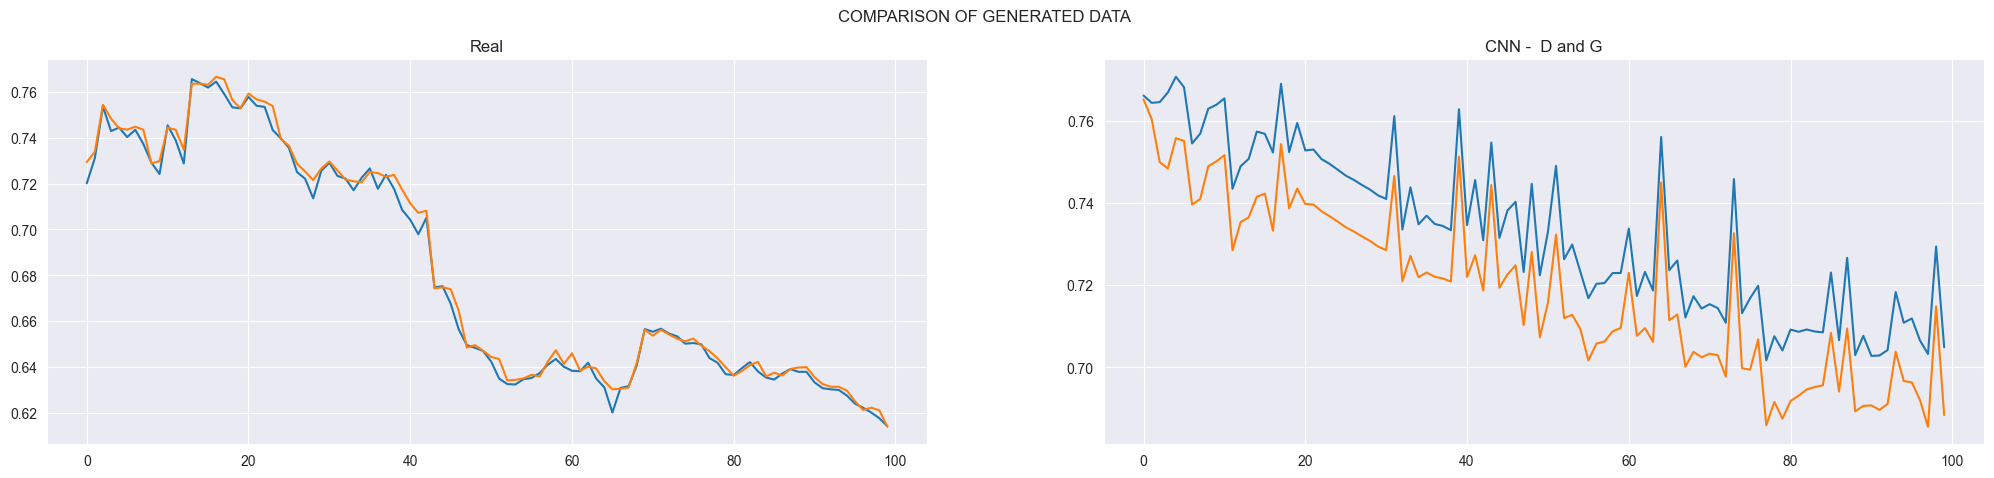

In [5]:
n = 19
fig, ax = plt.subplots(1,2, figsize=(25,5))

ax[0].plot(testset[:][0][n,:,0])
ax[0].plot(testset[:][0][n,:,1])
ax[0].set_title("Real")

ax[1].plot(gen_cnn[n,:,0])
ax[1].plot(gen_cnn[n,:,1])
ax[1].set_title("CNN -  D and G")

#ax[2].plot(gen_rnn[n,:,0])
#ax[2].plot(gen_rnn[n,:,1])
#ax[2].set_title("RNN")
plt.suptitle('COMPARISON OF GENERATED DATA')
plt.show()

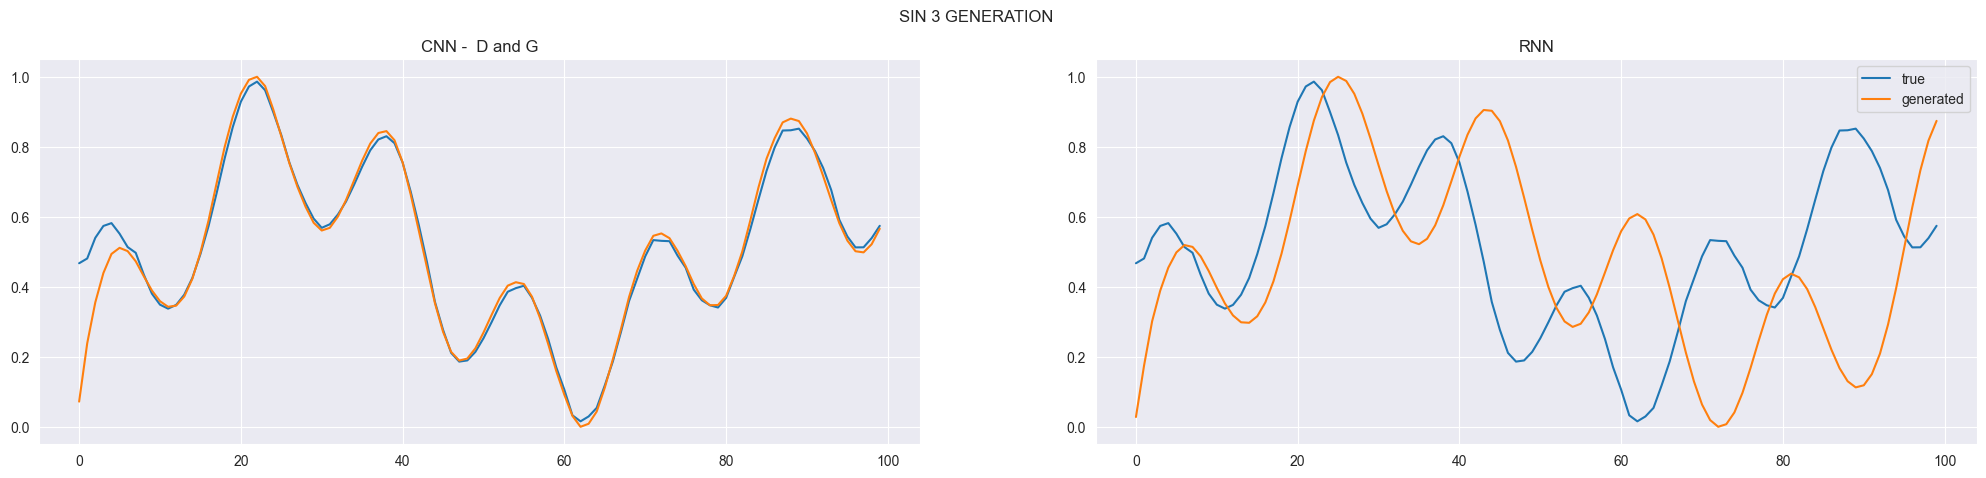

In [37]:
n = 13
gen_rnn_sin3 = create_sin3(gen_rnn[n][:,0], gen_rnn[n][:,1], temporal=True)
gen_cnn_sin3 = create_sin3(gen_cnn[n][:,0], gen_cnn[n][:,1], temporal=True)
gen_rnn_sin3_scaled = minmaxscaler().fit_transform(torch.tensor([gen_rnn_sin3]))[0]
gen_cnn_sin3_scaled = minmaxscaler().fit_transform(torch.tensor([gen_cnn_sin3]))[0]

fig, ax = plt.subplots(1,2, figsize=(25,5))

ax[0].plot(gen_cnn[n][:,2], label="true")
ax[0].plot(gen_cnn_sin3_scaled, label="generated")
ax[0].set_title("CNN -  D and G")

ax[1].plot(gen_cnn[n][:,2], label="true")
ax[1].plot(gen_rnn_sin3_scaled, label="generated")
ax[1].set_title("RNN")

plt.legend()
plt.suptitle("SIN 3 GENERATION")
plt.show()

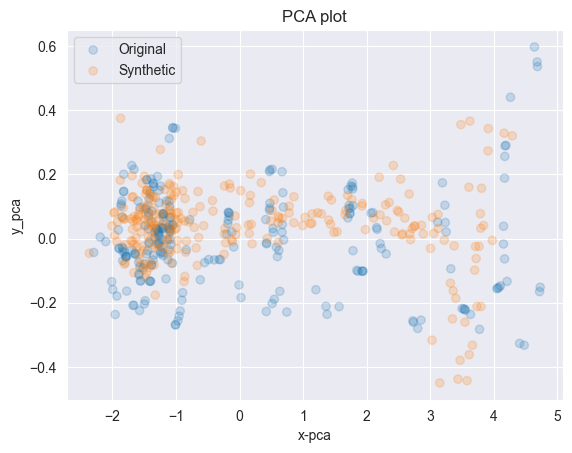

In [88]:
r = np.array([data[0].numpy() for data in testset])
f_pca = visualization(r, gen_cnn, 'pca')
#f_tsne = visualization(r, gen_rnn, 'tsne')

In [6]:
gen_cnn.shape

(250, 100, 6)

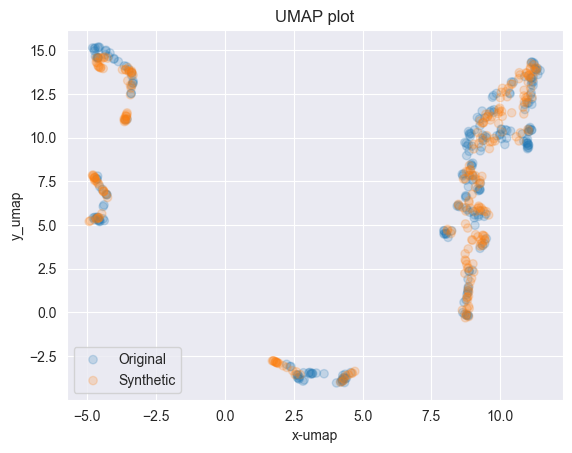

In [7]:
%autoreload
r = np.array([data[0].numpy() for data in testset])
f_pca = visualization(r, gen_cnn, 'umap')


In [1]:
import sklearn as sk
import seaborn as sns
fig, axes = plt.subplots(6,1, figsize=(10,10))

for col in [0,1,2,3,4,5]:
    sns.kdeplot(testset[:][0][:,:,col].flatten(), ax=axes[col-3], label="Real Sinus ")
    #sns.kdeplot(gen_rnn[:,:,col].flatten(), ax=axes[col], label="RNN Sinus ")
    sns.kdeplot(gen_cnn[:,:,col].flatten(), ax=axes[col-3], label="CNN Sinus ")
    plt.legend()
    axes[col].set_title("Feature " + str(col))
plt.suptitle("KDE-PLOT")




NameError: name 'plt' is not defined

In [75]:
%autoreload
from utils import *

In [76]:
seq_length = 100
data = google_data_loading(seq_length)
data.size()

from sklearn.model_selection import train_test_split
data_train, data_test = train_test_split(data)
trainset = TimeGANDatasetStocks(data_train)
testset = TimeGANDatasetStocks(data_test)

In [79]:
trainset[0][0].size()

torch.Size([100, 6])

In [74]:
trainset.size(), testset.size()

(torch.Size([2688, 100, 6]), torch.Size([897, 100, 6]))

In [66]:
def MinMaxScaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    return numerator / (denominator + 1e-7)

x = np.loadtxt('datasets/GOOGLE_BIG.csv', delimiter=",", skiprows=1)[::-1]
# x = torch.tensor(x.copy())
x = MinMaxScaler(x)

# Build dataset
dataX = []

# Cut data by sequence length
for i in range(0, len(x) - seq_length):
    _x = x[i:i + seq_length]
    dataX.append(_x)


np.array(dataX).shape

(3585, 100, 6)

In [2]:
%autoreload
import neptune.new as neptune
from utils import *
from architectures.timegan_cnn_DG import *
from trainers import timegan_generate_data

np.random.seed(42)
alpha = 0.7
noise = 0
testset = TimeGANDatasetSinus(num=300, seq_len=100, alpha=alpha, noise=noise)

run = neptune.init_run(with_id="TIMEGAN-84",
                       project="kohmann/timeGAN",api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI3YjFjNGY5MS1kOWU1LTRmZjgtOTNiYS0yOGI2NDdjZGYzNWUifQ==",
                       )
params = run["parameters"].fetch()
params["device"] = "cpu"

model = TimeGAN(params)
model = restore_weights(model, run)

https://app.neptune.ai/kohmann/timeGAN/e/TIMEGAN-84


Info (NVML): NVML Shared Library Not Found. GPU usage metrics may not be reported. For more information, see https://docs.neptune.ai/help/nvml_error/


Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 5 operations to synchronize with Neptune. Do not kill this process.
All 5 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/kohmann/timeGAN/e/TIMEGAN-84


In [3]:
fake_data = timegan_generate_data(model, torch.tensor(testset.T), params["max_seq_len"], params["Z_dim"])

#### Evaluation methods

In [200]:
%autoreload
from metrics import compare_sin3_generation, sinkhorn_distance, MMD
compare_sin3_generation(fake_data, 0.7, 0)

MSE Error: 0.00461


In [211]:
x = torch.tensor(fake_data)
y = testset[:][0]
wass_dist = sinkhorn_distance(x,y)
mmd = MMD(x,y)
print(f"Mean Wasserstein/Sinkhorn distance: {wass_dist.mean():.4f} ± {wass_dist.std():.4f}")
print(f"Mean MMD: {mmd.mean():.4f} ± {mmd.std():.4f}")

Mean Wasserstein/Sinkhorn distance: 0.0117 ± 0.0045
Mean MMD: 0.0110 ± 0.0019


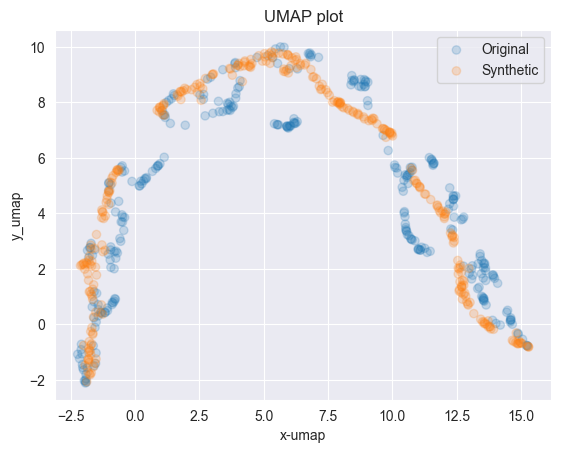

In [213]:
sin = 0
r = np.array([data[0].numpy() for data in testset])
f_pca = visualization(r[:,:,sin][:,:,None], fake_data[:,:,sin][:,:,None], 'umap')